In [1]:
import os
import scipy
import nltk
import gensim
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from gensim.models.fasttext import FastText
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
df = pd.read_pickle('metatable_preprocessed.pkl')[['tradition', 'country', 'text']]
df_traditions = pd.read_pickle('traditions.pkl')

In [5]:
df_traditions

,tradition,text,text_tokenized,text_pymystem_list,text_pymystem_pos_list
0,Американская литература,Земля. Вторая половина XXI в. Довольно заурядн...,"[земля, вторая, половина, xxi, в., довольно, з...","[земля, второй, половина, довольно, заурядный,...","[земля_NOUN, второй_ADJ, половина_NOUN, доволь..."
1,Античная литература,Герой романа Луций (случайно ли совпадение с и...,"[герой, романа, луций, случайно, ли, совпадени...","[герой, роман, луций, случайно, совпадение, им...","[герой_NOUN, роман_NOUN, луций_NOUN, случайно_..."
2,Британская литература,В семье Дарлингов трое детей-погодков. Старшая...,"[семье, дарлингов, трое, детей-погодков, старш...","[семья, дарлинг, трое, ребенок, погодок, старш...","[семья_NOUN, дарлинг_NOUN, трое_NUM, ребенок_N..."
3,Европейская литература,Действие происходит во время Великой Отечестве...,"[действие, происходит, во, время, великой, оте...","[действие, происходить, время, великий, отечес...","[действие_NOUN, происходить_VERB, время_NOUN, ..."
4,Латиноамериканская литература,Жительница небольшого городка Салвадора в окре...,"[жительница, небольшого, городка, салвадора, о...","[жительница, небольшой, городок, салвадор, окр...","[жительница_NOUN, небольшой_ADJ, городок_NOUN,..."
5,Прочая восточная литература,Роман состоит из пяти частей: первые четыре ча...,"[роман, состоит, из, пяти, частей, первые, чет...","[роман, состоять, пять, часть, первый, четыре,...","[роман_NOUN, состоять_VERB, пять_NUM, часть_NO..."
6,Прочая европейская литература,1807 год. Боснийский городок Травник на окраин...,"[1807, год, боснийский, городок, травник, на, ...","[год, боснийский, городок, травник, окраина, т...","[год_NOUN, боснийский_ADJ, городок_NOUN, травн..."
7,Прочая литература,Однажды в августе человек отправляется в трехд...,"[однажды, августе, человек, отправляется, трех...","[однажды, август, человек, отправляться, трехд...","[однажды_ADV, август_NOUN, человек_NOUN, отпра..."
8,Русская литература,На краю леса перед мельницей мельник Фаддей ст...,"[на, краю, леса, перед, мельницей, мельник, фа...","[край, лес, мельница, мельник, фаддей, строгат...","[край_NOUN, лес_NOUN, мельница_NOUN, мельник_N..."
9,Скандинавская литература,Жил-был злой тролль. Однажды он смастерил тако...,"[жил-был, злой, тролль, однажды, он, смастерил...","[жить, злой, тролль, однажды, смастерить, зерк...","[жить_VERB, злой_ADJ, тролль_NOUN, однажды_ADV..."


In [6]:
df.groupby(['tradition'])['tradition'].count()

tradition
Американская литература          201
Античная литература               49
Британская литература             21
Европейская литература           543
Латиноамериканская литература     14
Прочая восточная литература        7
Прочая европейская литература     24
Прочая литература                113
Русская литература               499
Скандинавская литература          39
Name: tradition, dtype: int64

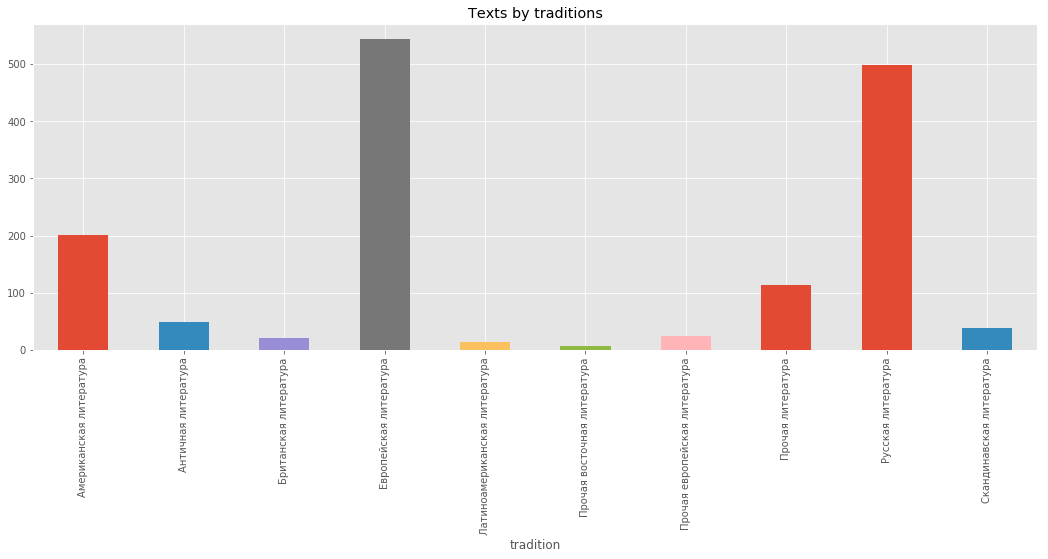

In [39]:
df.groupby(['tradition'])['tradition'].count().plot(kind="bar")
plt.title('Texts by traditions')
plt.rcParams['figure.figsize'] = (18, 6)

In [8]:
traditions = df_traditions.tradition.values

In [9]:
COUNT_VECT = CountVectorizer(tokenizer=lambda r: r, lowercase=False)
TF_VECT = TfidfVectorizer(tokenizer=lambda r: r, lowercase=False)

In [10]:
def plot_dendrogram(vectorizer, labels, texts, title):
    if vectorizer:
        if vectorizer == 'TF':
            vect = COUNT_VECT
        elif vectorizer == 'Count':
            vect = TF_VECT
    
        transformed = scipy.sparse.csr_matrix.toarray(vect.fit_transform(texts))
        res = linkage(transformed, method='complete')
        plt.title(vectorizer + '_vectorizer ' + title)
    else:
        res = linkage(texts, method='complete')
        plt.title(title)

    dendrogram(res, labels=labels, leaf_rotation=90)
    plt.show()

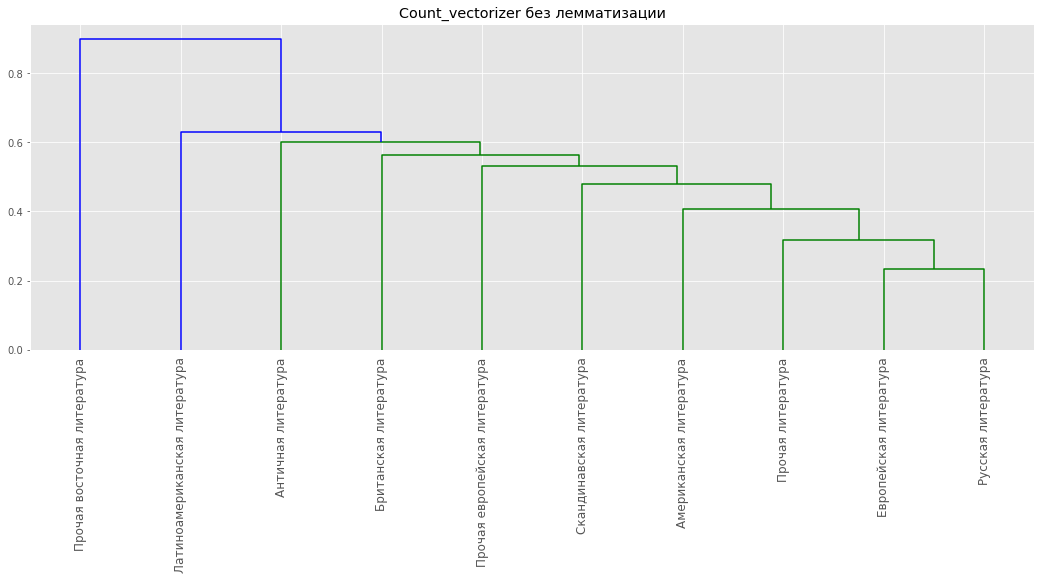

In [11]:
plot_dendrogram('Count', traditions, df_traditions.text_tokenized, 'без лемматизации')

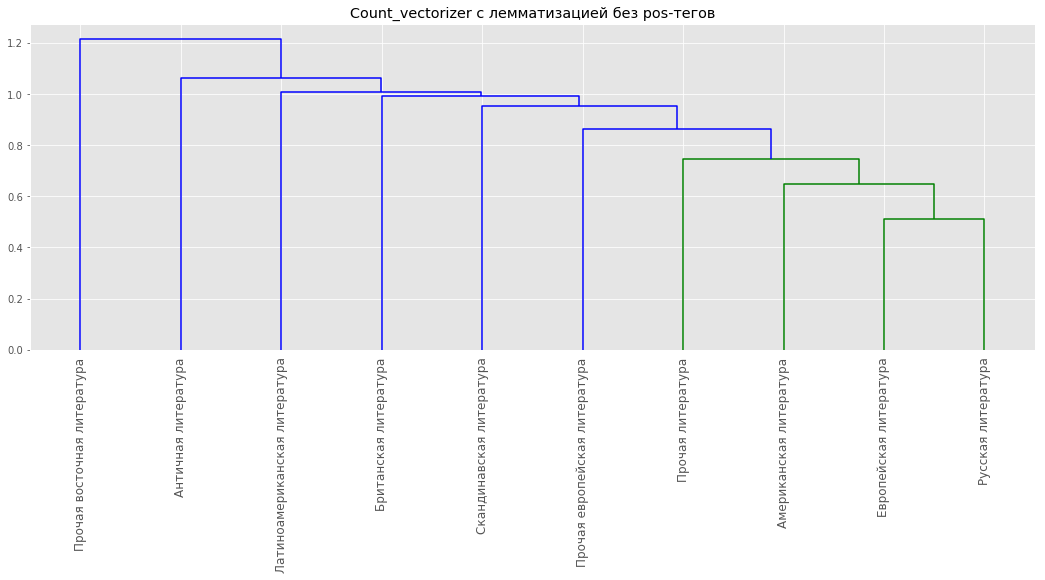

In [12]:
plot_dendrogram('Count', traditions, df_traditions.text_pymystem_list, 'с лемматизацией без pos-тегов')

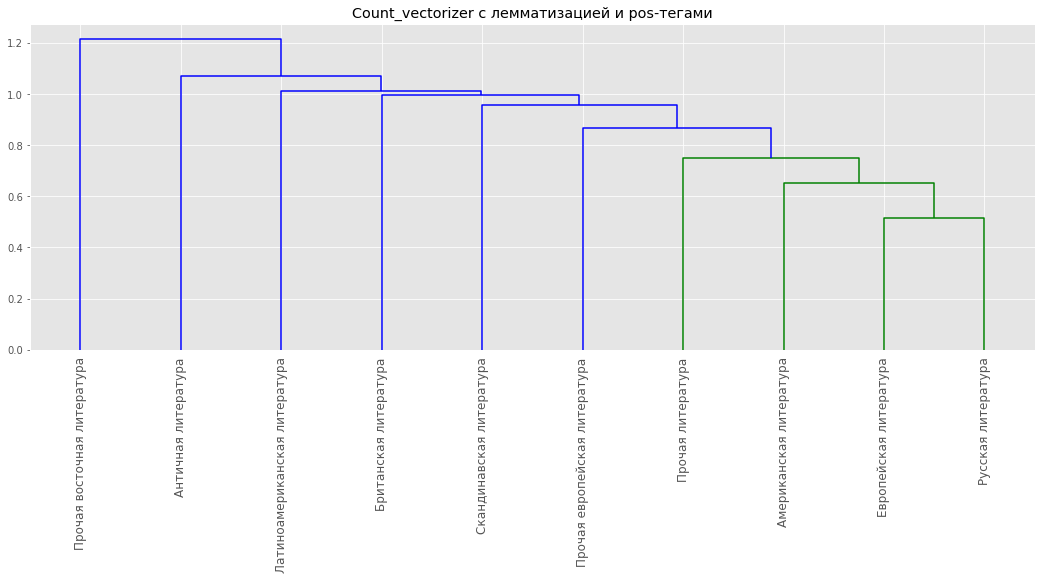

In [13]:
plot_dendrogram('Count', traditions, df_traditions.text_pymystem_pos_list, 'с лемматизацией и pos-тегами')

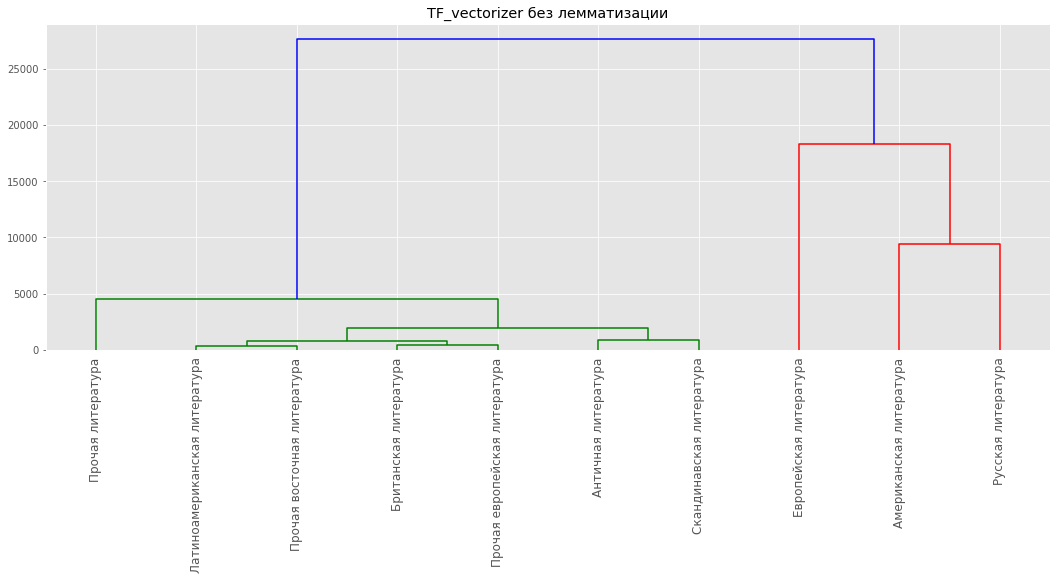

In [14]:
plot_dendrogram('TF', traditions, df_traditions.text_tokenized, 'без лемматизации')

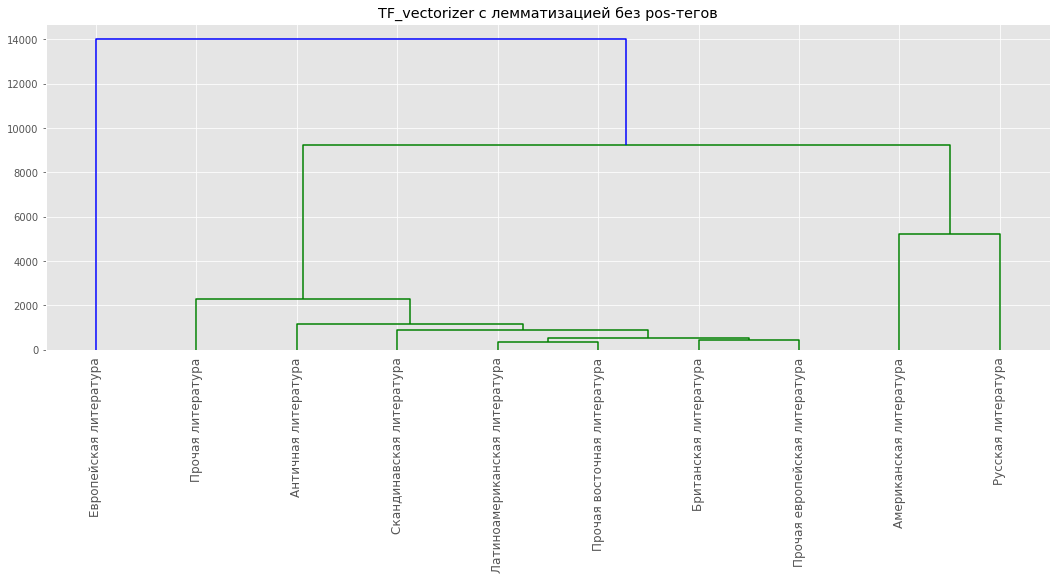

In [15]:
plot_dendrogram('TF', traditions, df_traditions.text_pymystem_list, 'c лемматизацией без pos-тегов')

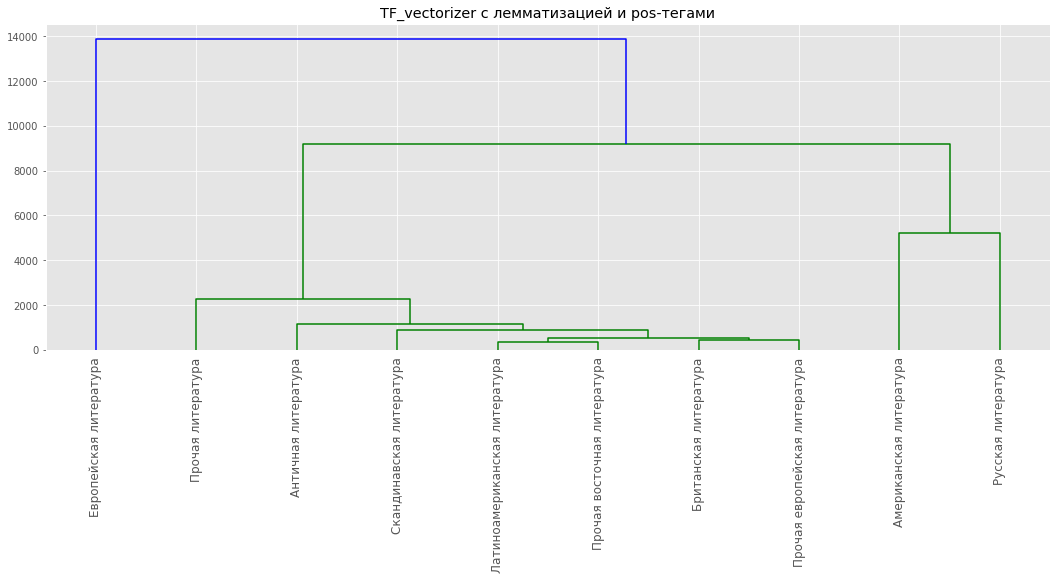

In [16]:
plot_dendrogram('TF', traditions, df_traditions.text_pymystem_pos_list, 'c лемматизацией и pos-тегами')

In [17]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [18]:
%%time

path = '/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model'
model = FastText.load(os.getcwd() + path)
model.init_sims(replace=True)

2018-09-30 20:18:31,346 : INFO : loading FastText object from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model
2018-09-30 20:18:34,804 : INFO : loading wv recursively from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.* with mmap=None
2018-09-30 20:18:34,811 : INFO : loading syn0_vocab from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0_vocab.npy with mmap=None
2018-09-30 20:18:35,631 : INFO : loading syn0 from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0.npy with mmap=None
2018-09-30 20:18:36,562 : INFO : setting ignored attribute syn0norm to None
2018-09-30 20:18:36,568 : INFO : setting ignored attr

CPU times: user 10.7 s, sys: 3.56 s, total: 14.3 s
Wall time: 23.8 s


In [19]:
%%time

tradition_vec = word_averaging_list(model.wv, df_traditions.text_pymystem_list)

CPU times: user 3.6 s, sys: 617 ms, total: 4.22 s
Wall time: 4.22 s


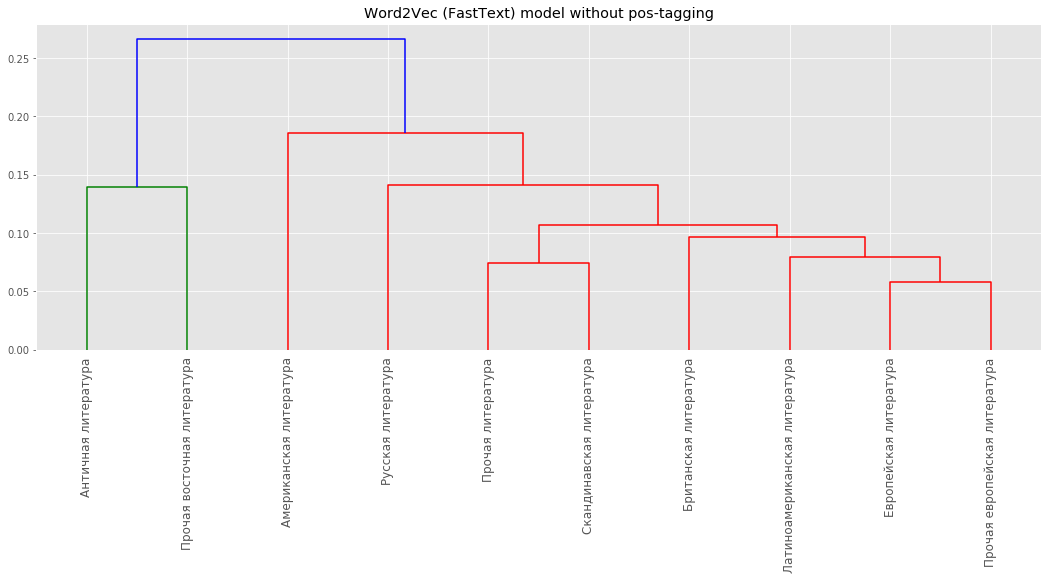

In [20]:
plot_dendrogram(None, traditions, tradition_vec, 'Word2Vec (FastText) model without pos-tagging')

In [21]:
%%time

path_2 = 'ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz'
model_2 = KeyedVectors.load_word2vec_format(path_2, binary=False)
model_2.init_sims(replace=True)

2018-09-30 20:18:59,762 : INFO : loading projection weights from ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz
2018-09-30 20:21:55,520 : INFO : loaded (384764, 300) matrix from ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz
2018-09-30 20:21:55,527 : INFO : precomputing L2-norms of word weight vectors


CPU times: user 2min 59s, sys: 1.86 s, total: 3min 1s
Wall time: 3min 1s


In [22]:
%%time

tradition_vec_pos = word_averaging_list(model_2.wv, df_traditions.text_pymystem_pos_list)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


CPU times: user 5.64 s, sys: 2.05 s, total: 7.69 s
Wall time: 16 s


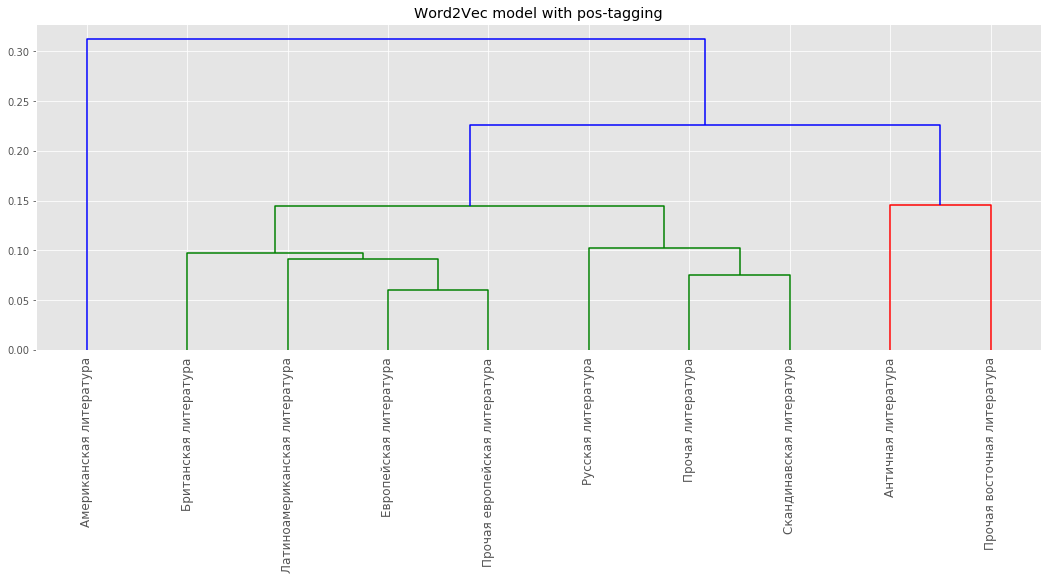

In [23]:
plot_dendrogram(None, traditions, tradition_vec_pos, 'Word2Vec model with pos-tagging')

In [24]:
df_countries = pd.read_pickle('countries.pkl')

In [25]:
df_countries.head()

,country,text,text_tokenized,text_pymystem_list,text_pymystem_pos_list
0,18 век,На краю леса перед мельницей мельник Фаддей ст...,"[на, краю, леса, перед, мельницей, мельник, фа...","[край, лес, мельница, мельник, фаддей, строгат...","[край_NOUN, лес_NOUN, мельница_NOUN, мельник_N..."
1,19 век,Собирается богатый купец по делам торговым в т...,"[собирается, богатый, купец, по, делам, торгов...","[собираться, богатый, купец, дело, торговый, т...","[собираться_VERB, богатый_ADJ, купец_NOUN, дел..."
2,Австралийская,Повествование ведётся от лица Смерти — бессмер...,"[повествование, ведётся, от, лица, смерти, бес...","[повествование, вестись, лицо, смерть, бессмер...","[повествование_NOUN, вестись_VERB, лицо_NOUN, ..."
3,Австрийская,Время и место действия драматургом не определе...,"[время, место, действия, драматургом, не, опре...","[время, место, действие, драматург, определять...","[время_NOUN, место_NOUN, действие_NOUN, драмат..."
4,Аргентинская,Вселенная — некоторые называют ее Библиотекой ...,"[вселенная, некоторые, называют, ее, библиотек...","[вселенная, некоторые, называть, библиотека, с...","[вселенная_NOUN, некоторые_PRON, называть_VERB..."


In [26]:
df.groupby(['country'])['country'].count()

country
18 век              39
19 век             129
Австралийская        8
Австрийская         22
Аргентинская         6
Армянская            1
Белорусская          7
Бельгийская          6
Бразильская          3
Британская         156
Гватемальская        1
Грузинская           1
Датская             10
Древнегреческая     34
Древнеримская       15
Древность            7
Еврейская           14
Индийская           16
Ирландская           5
Исландская           1
Испанская           27
Итальянская         48
Китайская           42
Колумбийская         2
Кубинская            1
Немецкая            81
Нидерландская        1
Норвежская          12
Персидская           4
Польская            18
Португальская        1
США                201
Советская          273
Современная         51
Турецкая             1
Украинская           1
Финская              1
Французская        183
Чешская              4
Чилийская            1
Шведская            15
Швейцарская         11
Шотландская         16
Юго

Text(0.5,1,'Texts by countries')

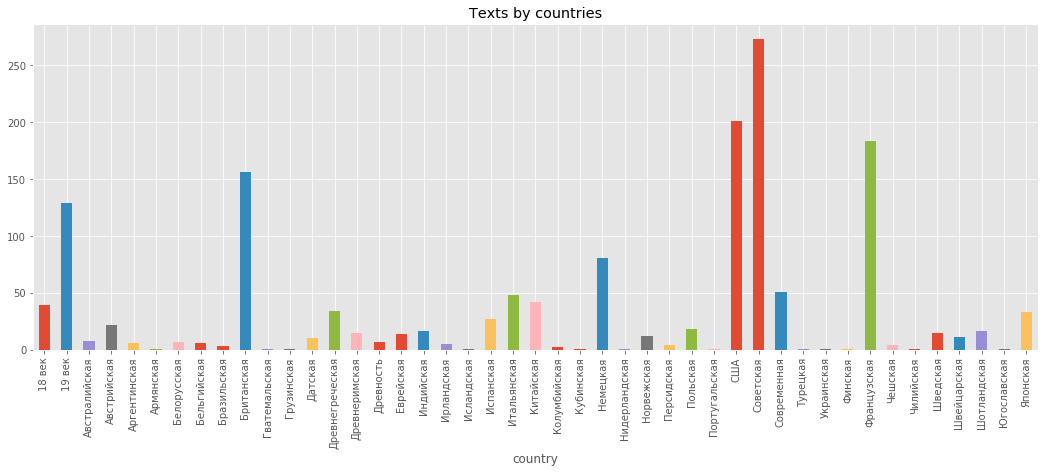

In [27]:
df.groupby(['country'])['country'].count().plot(kind="bar")
plt.title('Texts by countries')

In [28]:
countries = df_countries.country.values

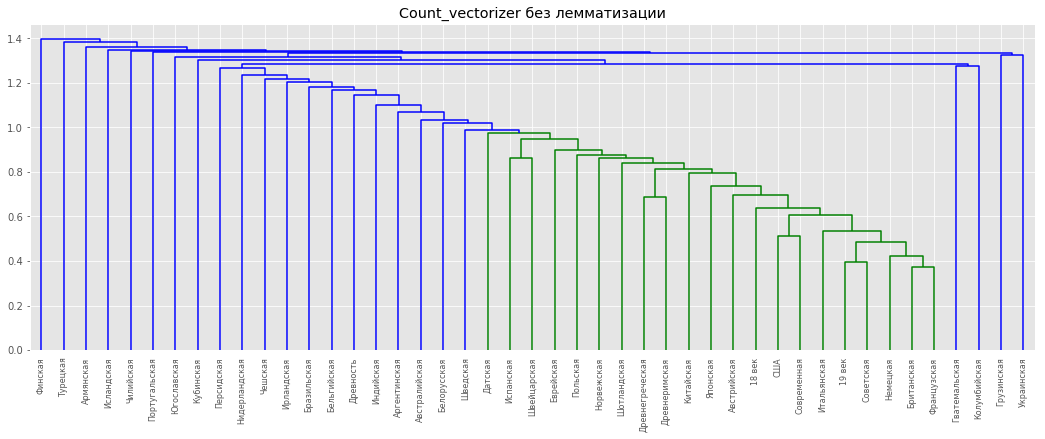

In [29]:
plot_dendrogram('Count', countries, df_countries.text_tokenized, 'без лемматизации')

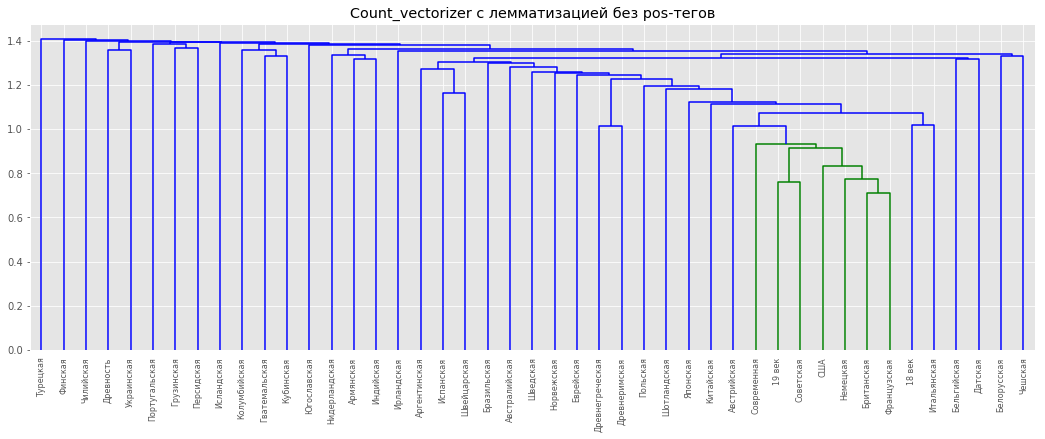

In [30]:
plot_dendrogram('Count', countries, df_countries.text_pymystem_list, 'с лемматизацией без pos-тегов')

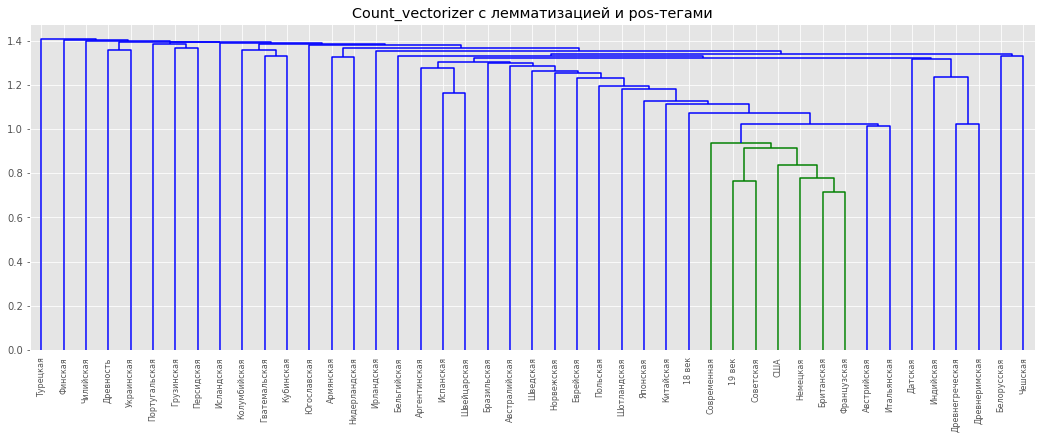

In [31]:
plot_dendrogram('Count', countries, df_countries.text_pymystem_pos_list, 'с лемматизацией и pos-тегами')

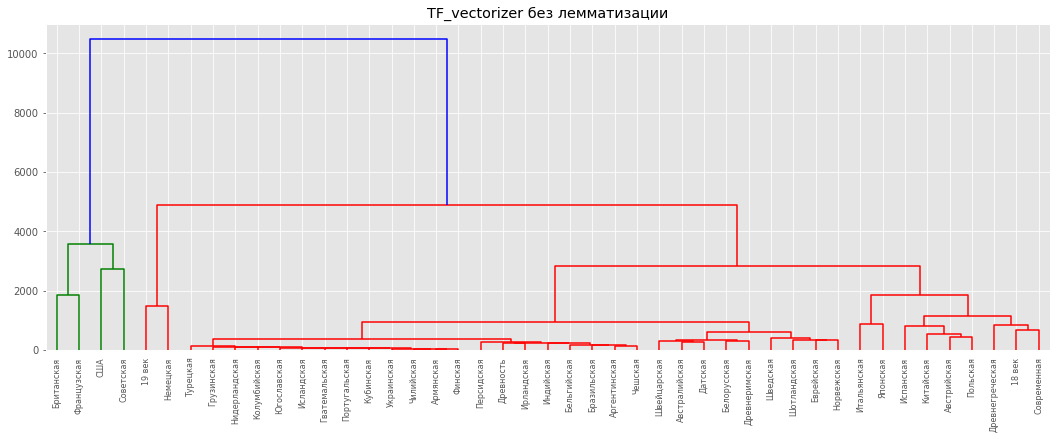

In [32]:
plot_dendrogram('TF', countries, df_countries.text_tokenized, 'без лемматизации')

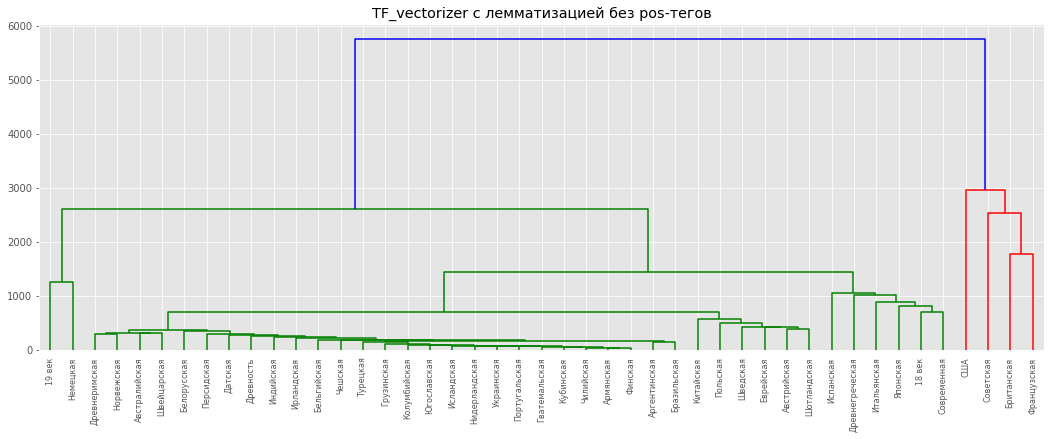

In [33]:
plot_dendrogram('TF', countries, df_countries.text_pymystem_list, 'c лемматизацией без pos-тегов')

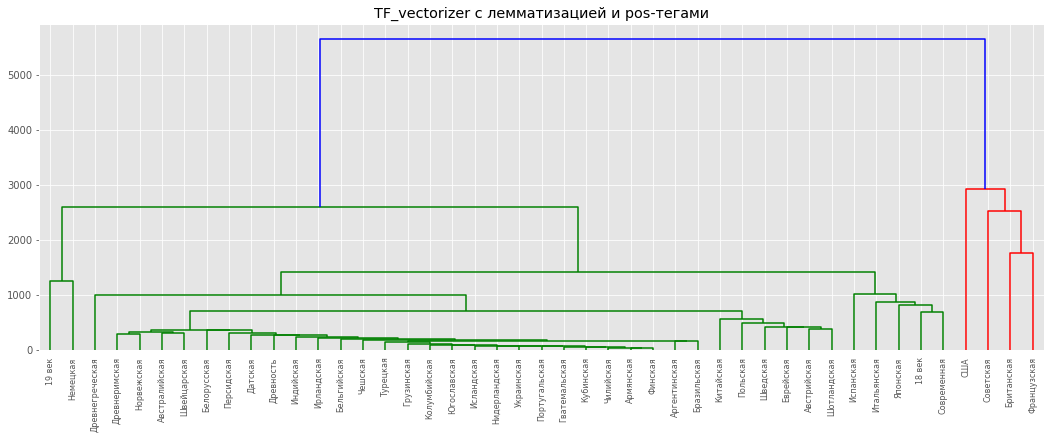

In [34]:
plot_dendrogram('TF', countries, df_countries.text_pymystem_pos_list, 'c лемматизацией и pos-тегами')

In [35]:
%%time

country_vec = word_averaging_list(model.wv, df_countries.text_pymystem_list)

CPU times: user 5.65 s, sys: 1.85 s, total: 7.5 s
Wall time: 16.7 s


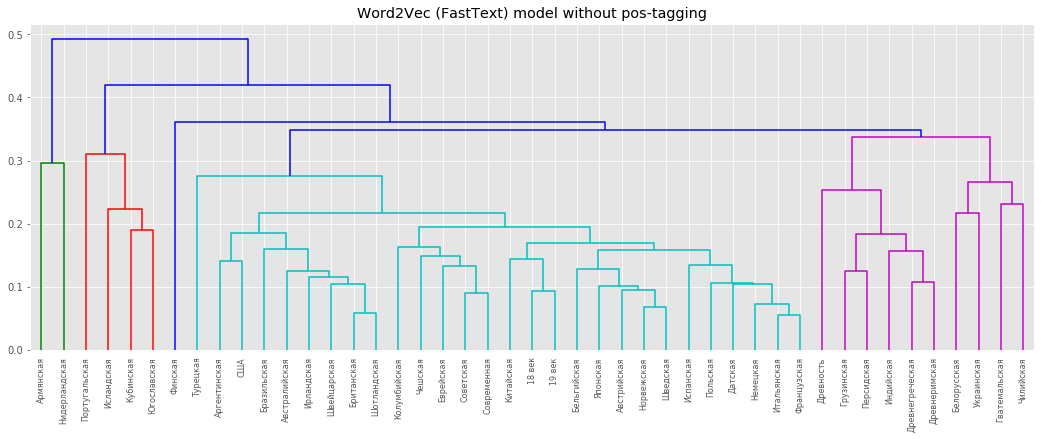

In [36]:
plot_dendrogram(None, countries, country_vec, 'Word2Vec (FastText) model without pos-tagging')

In [37]:
%%time

country_vec_pos = word_averaging_list(model_2.wv, df_countries.text_pymystem_pos_list)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


CPU times: user 3.86 s, sys: 484 ms, total: 4.34 s
Wall time: 4.35 s


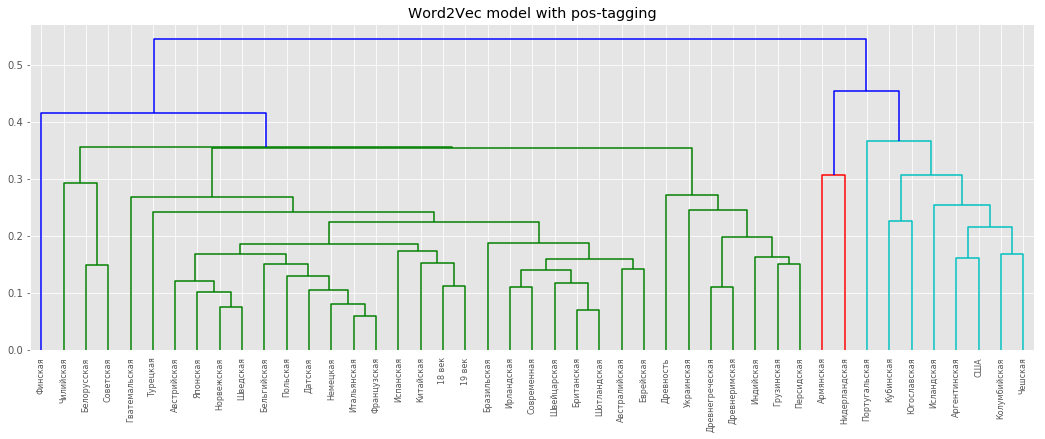

In [38]:
plot_dendrogram(None, countries, country_vec_pos, 'Word2Vec model with pos-tagging')